In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from bs4 import BeautifulSoup     
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.cross_validation import cross_val_score, cross_val_predict, train_test_split
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
from nltk.stem.porter import PorterStemmer
import re
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
% matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
df = pd.read_csv('./snoo.csv', index_col=0)

In [5]:
df.head()

,Comments,Subreddits,Time,Titles,Upvotes
0,342,NintendoSwitch,1519183023000,"Less 'rip and tear', more 'post and snark'...",9853
1,556,videos,1519179050000,Heavy rain leaves trail under cristaline water...,13543
2,907,todayilearned,1519176061000,TIL that comedian Ryan Stiles from Whose Line ...,55462
3,83,aww,1519176707000,All grown up🐕,16440
4,809,gaming,1519176342000,Modern Warfare 2,22538


In [6]:
#Dropping duplicate observations. Keeping the last duplicate as it will have the highest number of comments.
snoo = df.drop_duplicates(subset=['Titles', 'Subreddits'], keep='last', inplace=False)

In [7]:
#Curious to see how many observations I dropped (down from 40000)
snoo.shape

(24631, 5)

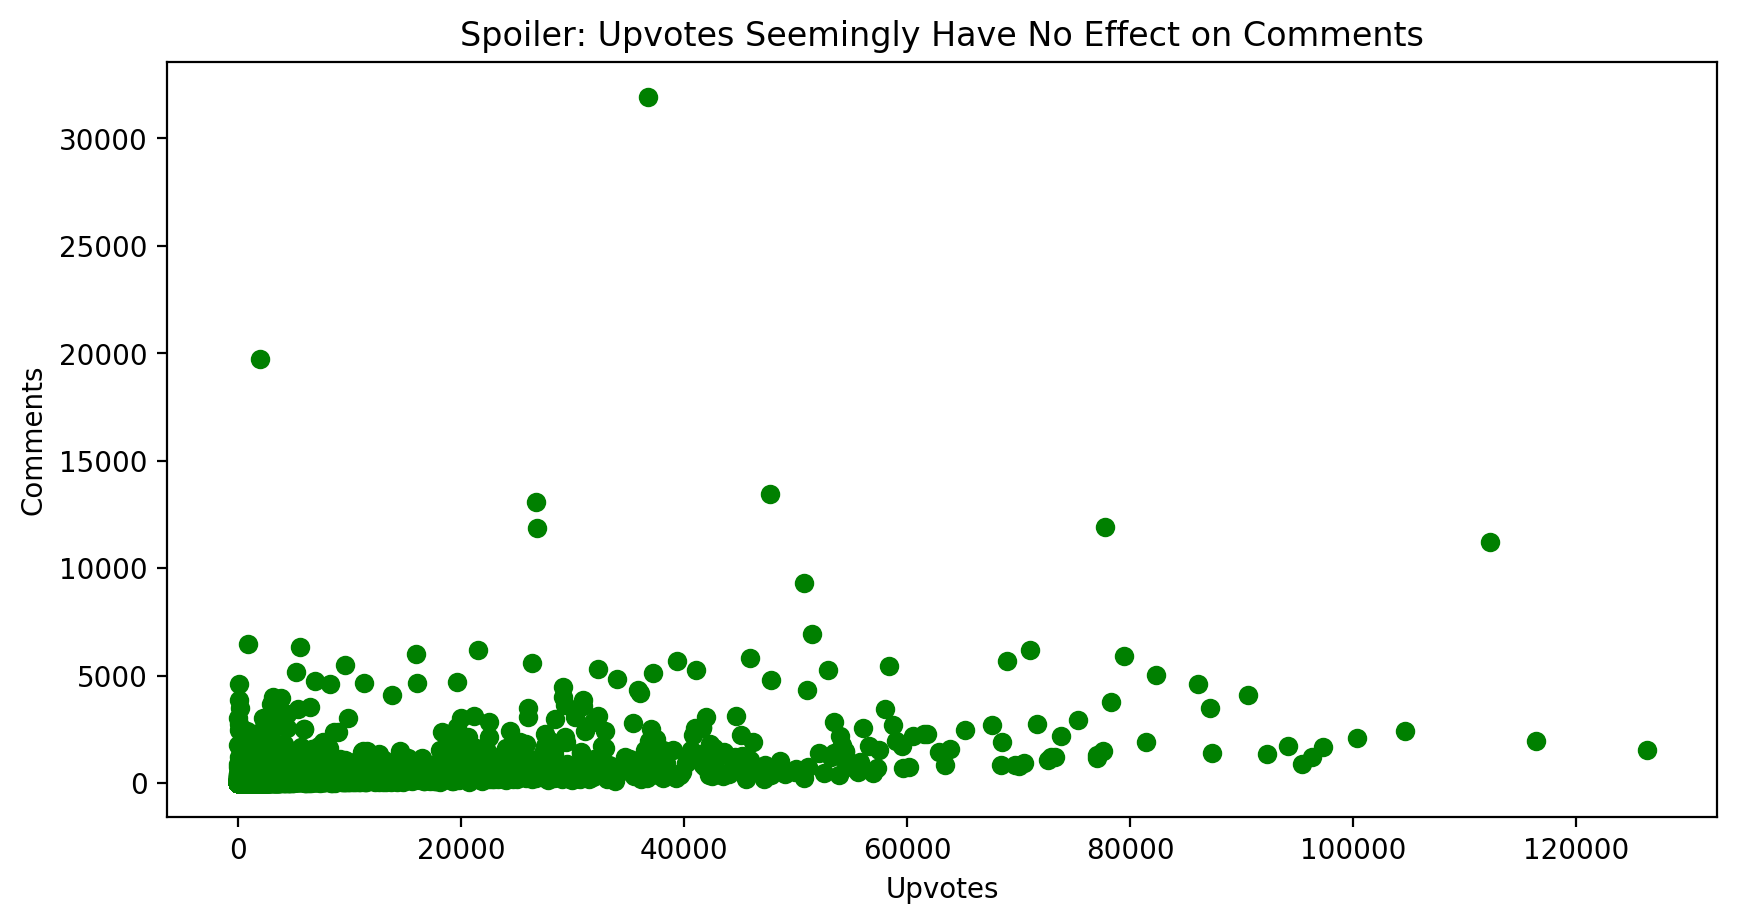

In [94]:
#Checking for a relationship between comments and upvotes
plt.figure(figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(snoo['Upvotes'],snoo['Comments'], c='g')
plt.xlabel('Upvotes')
plt.ylabel('Comments')
plt.title("Spoiler: Upvotes Seemingly Have No Effect on Comments");

In [30]:
#The prompt asks for the median
print(snoo['Comments'].median())
print(snoo['Upvotes'].median())

19.0
212.0


In [10]:
snoo.columns

Index(['Comments', 'Subreddits', 'Time', 'Titles', 'Upvotes'], dtype='object')

In [11]:
#Checking that my features are in the units I'd like
snoo.dtypes

Comments       int64
Subreddits    object
Time           int64
Titles        object
Upvotes        int64
dtype: object

In [12]:
snoo.head()

,Comments,Subreddits,Time,Titles,Upvotes
10,252,BlackPeopleTwitter,1519171983000,Planned this outfit days in advance,12849
5,1240,reactiongifs,1519164511000,MRW another white person walks into the Theatr...,40574
24,49,memes,1519173367000,kermit savage af,3654
0,70,CrazyIdeas,1519179008000,Poke holes in all the condoms given out for th...,1851
3,218,funny,1519168597000,Oh crap!,21731


In [16]:
#Changing the Time feature to datetime and then converting from UTC to EST
snoo['Time'] = pd.to_datetime(snoo.Time, unit='ms')
snoo['Time'] = snoo['Time'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
snoo.head()

,Comments,Subreddits,Time,Titles,Upvotes
10,252,BlackPeopleTwitter,2018-02-20 19:13:03-05:00,Planned this outfit days in advance,12849
5,1240,reactiongifs,2018-02-20 17:08:31-05:00,MRW another white person walks into the Theatr...,40574
24,49,memes,2018-02-20 19:36:07-05:00,kermit savage af,3654
0,70,CrazyIdeas,2018-02-20 21:10:08-05:00,Poke holes in all the condoms given out for th...,1851
3,218,funny,2018-02-20 18:16:37-05:00,Oh crap!,21731


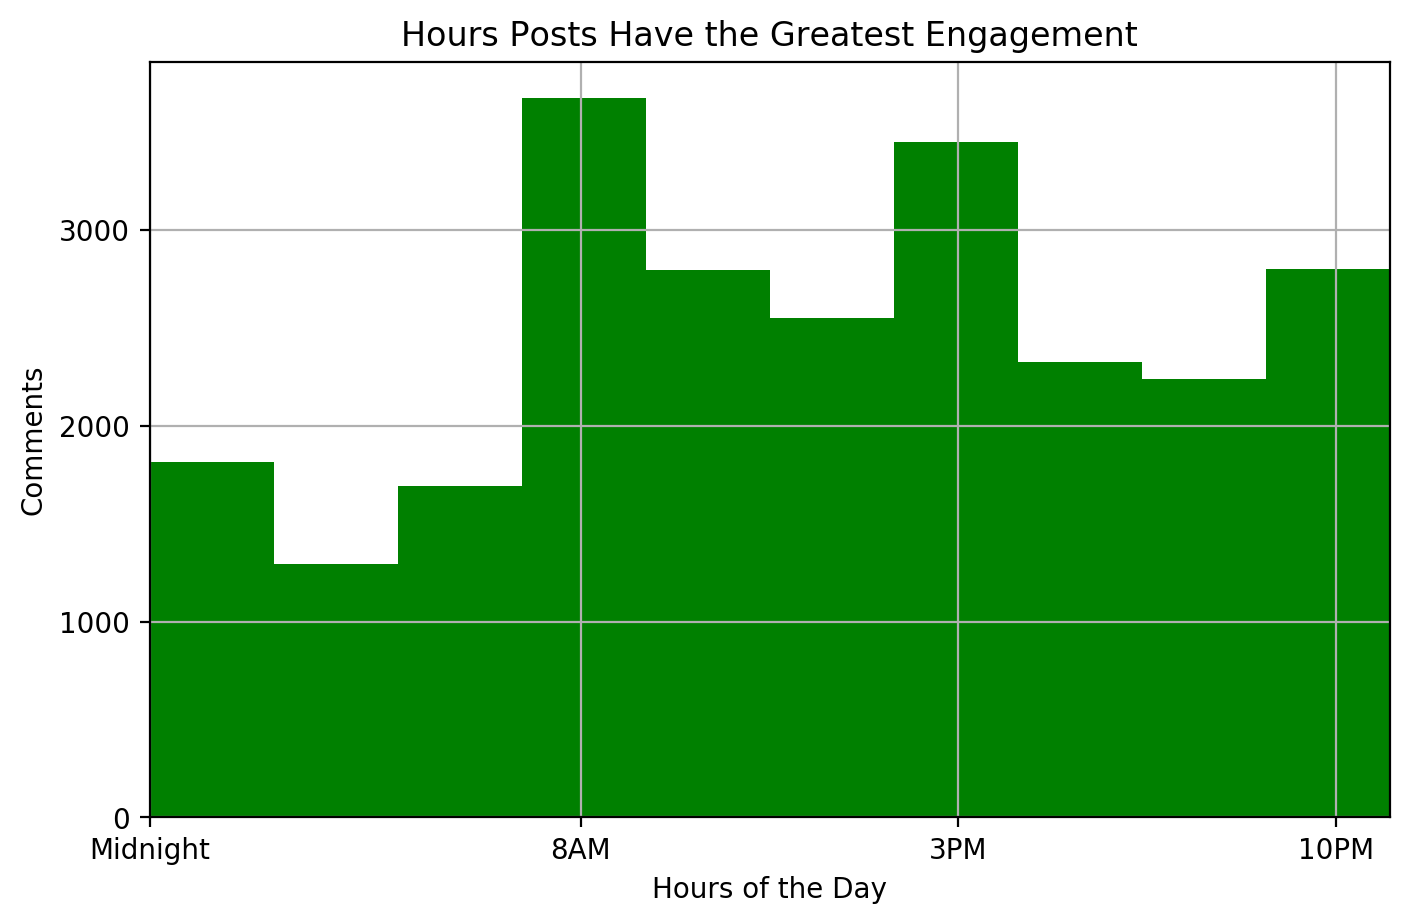

In [90]:
#When are comments highest?
plt.figure(figsize=(8, 5), dpi=100, facecolor='w', edgecolor='k')
snoo.Time.dt.hour.hist(color='green')
plt.ylabel("Comments")
plt.xlabel("Hours of the Day")
plt.xlim(xmin=0, xmax=23)
plt.xticks([0,8,15,22], ['Midnight', '8AM', '3PM', '10PM'])
plt.yticks([0, 1000, 2000, 3000])
plt.title("Hours Posts Have the Greatest Engagement");

In [18]:
#Let's check which subreddits appear in r/all the most
snoo['Subreddits'].value_counts()[0:25]

politics                79
funny                   76
The_Donald              72
offlineTV               68
dankmemes               67
aww                     64
FortNiteBR              64
nba                     61
FireEmblemHeroes        61
rupaulsdragrace         60
Rainbow6                59
DDLC                    59
Animemes                58
gaming                  58
GlobalOffensive         57
hockey                  57
PewdiepieSubmissions    57
memes                   56
PrequelMemes            56
CryptoCurrency          56
BlackPeopleTwitter      55
CringeAnarchy           55
tumblr                  55
soccer                  54
CBTS_Stream             54
Name: Subreddits, dtype: int64

In [15]:
#Creating a boolean based on the median number of comments
snoo['comments_high_low'] = np.where(snoo['Comments']>19.0, 'High', 'Low')

### Natural Language Processing

In [16]:
#Setting up data for use in modeling 
X = snoo['Subreddits']
y = snoo['comments_high_low']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1016)

In [18]:
#Making sure my shapes match
print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(24631,) (24631,)
(17241,) (17241,)
(7390,) (7390,)


In [19]:
cvec = CountVectorizer(max_features=2000)

In [20]:
cvecdata = cvec.fit_transform(X_train)

In [21]:
snooqt  = pd.DataFrame(cvecdata.todense(),
             columns=cvec.get_feature_names())

In [23]:
tvec = TfidfVectorizer()
tvec.fit(X_train, y_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [24]:
snooqtpi  = pd.DataFrame(tvec.transform(X_train, y_train).todense(),
                   columns=tvec.get_feature_names(),
                   index=[X_train, y_train])

In [25]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1016)

In [26]:
#cvec random forest
dt = RandomForestClassifier()
s = cross_val_score(dt, snooqt, y_train, cv=cv, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

Random Forest Score:	0.684 ± 0.006


In [27]:
cvecdata2 = cvec.transform(X_test)

In [28]:
snooqt2  = pd.DataFrame(cvecdata2.todense(),
             columns=cvec.get_feature_names())

In [29]:
dt = RandomForestClassifier()
s = cross_val_score(dt, snooqt2, y_test, cv=cv, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

Random Forest Score:	0.664 ± 0.013


In [30]:
snooqt2.head()

,100yearsago,195,2007scape,2healthbars,3amjokes,3dprinting,3ds,40klore,49ers,4chan,...,youtubehaiku,yovannaventura,yugioh,yuzumiko,zelda,zerotwo,zerowaste,zettairyouiki,zoomies,zootopia
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
#tfidf random forest
dt = RandomForestClassifier()
s = cross_val_score(dt, snooqtpi, y_train, cv=cv, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

Random Forest Score:	0.684 ± 0.007


In [32]:
snooqtpi2  = pd.DataFrame(tvec.transform(X_test, y_test).todense(),
                   columns=tvec.get_feature_names(),
                   index=[X_test, y_test])

In [40]:
d = {'High': True, 'Low': False}

In [51]:
snooqtpi2 = snooqtpi2.reset_index()

In [53]:
snooqtpi2.comments_high_low = snooqtpi2['comments_high_low'].map(d)

In [63]:
snooqtpi2 = snooqtpi2.set_index('Subreddits')

In [34]:
dt = RandomForestClassifier()
s = cross_val_score(dt, snooqtpi2, y_test, cv=cv, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

Random Forest Score:	0.666 ± 0.014


#### Running a logistic regression

In [64]:
y = snooqtpi2['comments_high_low'].values
X = snooqtpi2.drop('comments_high_low')
logreg = LogisticRegression()
logreg.fit(X, y)
score = logreg.score(X, y)
print(score)

1.0
